# Импорт библиотек и данных

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import re

%matplotlib inline

sns.set_style('darkgrid')

from IPython.display import display, display_html, HTML

root_folder = '../'
sys.path.append(root_folder)
# from src.data import make_dataset
from src import utils
from src.features import build_features
from src.visualization import visualize

interim_data = Path(root_folder, 'data', 'interim', '1.0_first_process.csv')
# baseline_data = Path(root_folder, 'data', 'processed', '1.0_baseline.csv')

In [2]:
df = pd.read_csv(
    interim_data,
    index_col=0
)
# IMPORTANT FOR FURTHER LIST ANALYSIS!
df = build_features.get_df_with_lists(df)
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 374305
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                333918 non-null  object 
 1   street                372469 non-null  object 
 2   baths                 267467 non-null  float64
 3   fireplace             374306 non-null  bool   
 4   city                  374272 non-null  object 
 5   sqft                  333384 non-null  float64
 6   zipcode               374306 non-null  object 
 7   beds                  277504 non-null  float64
 8   state                 374306 non-null  object 
 9   stories               221109 non-null  float64
 10  target                374306 non-null  int64  
 11  marked_interior_area  374306 non-null  bool   
 12  private_pool          374306 non-null  bool   
 13  mls                   374306 non-null  bool   
 14  property_type         333572 non-null  object 
 15  year_

,status,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,...,remodeled_year,heating,cooling,parking,lotsize,price/sqft,school_rating,school_distance,school_grades,school_name
0,active,240 Heather Ln,3.5,True,Southern Pines,2900.0,28387,4.0,NC,NaN,...,NaN,"Central A/C, Heat Pump",NaN,NaN,NaN,$144,"[4, 4, 7, NR, 4, 7, NR, NR]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[Southern Pines Elementary School, Southern Mi..."
1,sale,12911 E Heroy Ave,3.0,False,Spokane Valley,1947.0,99216,3.0,WA,2.0,...,NaN,NaN,NaN,NaN,5828.0,$159/sqft,"[4/10, null/10, 4/10]","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, PK-8]","[East Valley High School&Extension, Eastvalley..."
2,sale,2005 Westridge Rd,2.0,True,Los Angeles,3000.0,90049,3.0,CA,1.0,...,1967.0,Forced Air,Central,Attached Garage,8626.0,$965/sqft,"[8/10, 4/10, 8/10]","[1.19mi, 2.06mi, 2.63mi]","[6-8, K-5, 9-12]","[Paul Revere Middle School, Brentwood Science ..."
3,sale,4311 Livingston Ave,8.0,True,Dallas,6457.0,75205,5.0,TX,3.0,...,2006.0,Forced Air,Central,Detached Garage,8220.0,$371/sqft,"[9/10, 9/10, 10/10, 9/10]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","[5-6, PK-4, 7-8, 9-12]","[Mcculloch Intermediate School, Bradfield Elem..."
4,sale,1524 Kiscoe St,NaN,False,Palm Bay,NaN,32908,NaN,FL,NaN,...,NaN,NaN,NaN,NaN,10019.0,NaN,"[4/10, 5/10, 5/10]","[5.96mi, 3.25mi, 3.03mi]","[7-8, 9-12, PK-6]","[Southwest Middle School, Bayside High School,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374301,NaN,20800 NE 23rd Ave,6.0,False,Miami,4017.0,33180,5.0,FL,NaN,...,1990.0,Other,Central,2 spaces,8500.0,$311,"[10/10, 5/10]","[32.1 mi, 1.1 mi]","[PK-8, 9-12]","[Air Base Elementary School, Dr Michael M. Kro..."
374302,sale,3530 N Lake Shore Dr #4B,3.0,False,Chicago,2000.0,60657,3.0,IL,9.0,...,NaN,Radiant,NaN,NaN,NaN,$337/sqft,"[1/10, 5/10, 7/10]","[10.61mi, 1.42mi, 0.4mi]","[9-12, 9-12, PK-8]","[Hope College Prep High School, Lake View High..."
374303,sale,15509 Linden Blvd,3.0,False,Jamaica,1152.0,11434,3.0,NY,2.0,...,1950.0,Other,NaN,2,1600.0,$458/sqft,"[5/10, 4/10]","[0.48mi, 0.73mi]","[PK-5, 6-8]","[Ps 48 William Wordsworth, Jhs 8 Richard S Gro..."
374304,NaN,7810 Pereida St,NaN,False,Houston,NaN,77028,NaN,TX,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[NA, NA, NA]","[1.3 mi, 0.5 mi, 1.9 mi]","[PK-5, 6-8, 9-12]","[Hiliard El, Forest Brook Middle, North Forest..."


# Подготовка признаков

Займёмся более серьезной обработкой признаков:
- parking
- heating
- cooling

- school_rating
- school_distance
- school_grades
- school_name 

- remodeled_year (комбинация с build_year)
- price/sqft (удаляется)

TODO:
- process `parking`

In [3]:
df[df['parking'].str.contains(r'[^0-9]', regex=True, na=False)]['parking'].value_counts().head(20)

parking
Attached Garage                     70244
2 spaces                            27867
1 space                             14109
Detached Garage                     13094
No Data                             13023
Carport                              7664
3 spaces                             4702
Off Street                           3563
Carport, Attached Garage             3006
4 spaces                             2900
Off street                           1639
Attached Garage, Detached Garage     1334
On Street                            1237
Attached Garage, Carport              987
Parking Desc                          900
6 spaces                              748
Detached Garage, Attached Garage      720
Driveway                              693
5 spaces                              654
On street                             460
Name: count, dtype: int64

Впоследствии, можно будет ввести "years from last remodeling" - сколько лет с последнего ремонта.

In [ ]:
(df['remodeled_year'] - df['year_built']).value_counts().head(20)

0.0     85948
1.0     10689
5.0      2377
10.0     2061
6.0      1479
2.0      1463
20.0     1379
15.0     1362
9.0      1324
8.0      1321
16.0     1198
3.0      1151
4.0      1135
14.0     1133
7.0      1129
30.0     1010
12.0      987
11.0      951
13.0      899
18.0      870
Name: count, dtype: int64

# Очистка датасета

In [4]:
service_cols = [
    'marked_interior_area',
    'price/sqft'
]

advert_cols = [
    'status',
    'mls',
]

address_cols = [
    'zipcode',
    'state',
    'city',
    'street'
]

home_property_cols = [
    'property_type',
    'sqft',
    'lotsize',
    'stories',
    'baths',
    'beds',
    'fireplace',
    'private_pool',
    'year_built',
    'remodeled_year'
]

unprocessed_property_cols = [
    'heating',
    'cooling',
    'parking',
]

school_data = [
    'school_rating',
    'school_distance',
    'school_grades',
    'school_name'
]

check_duplicates_cols = [
    'target',
    *advert_cols,
    *address_cols,
    *home_property_cols,
]
duplicated_mask = df[check_duplicates_cols].duplicated()
duplicates_cnt = duplicated_mask.sum()
print('Количество дубликатов (без необработанных):', duplicates_cnt)

check_full_duplicates_cols = check_duplicates_cols.copy()
check_full_duplicates_cols.extend(unprocessed_property_cols)
full_duplicated_mask = df[check_full_duplicates_cols].duplicated()
full_duplicates_cnt = full_duplicated_mask.sum()
print('Количество полных дубликатов:', full_duplicates_cnt)

Количество дубликатов (без необработанных): 2770
Количество полных дубликатов: 441


In [58]:
duplicated_mask_all = df[check_duplicates_cols].duplicated(keep=False)
full_duplicated_mask_all = df[check_full_duplicates_cols].duplicated(keep=False)

df[duplicated_mask_all & ~full_duplicated_mask_all]

,status,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,...,remodeled_year,heating,cooling,parking,lotsize,price/sqft,school_rating,school_distance,school_grades,school_name
46,sale,4547 Cascades Shoreline Dr,5.0,True,Tyler,5358.0,75709,5.0,TX,2.0,...,2005.0,Other,Central,3 spaces,0.91 acres lot,$267,"[4/10, 5/10, 2/10]","[1.7 mi, 3.5 mi, 2.8 mi]","[PK-5, 6-8, 9-12]","[Dixie Elementary School, Three Lakes Middle, ..."
115,sale,800 Georgetown Pl,3.0,False,San Jose,1859.0,95126,3.0,CA,3.0,...,2002.0,Forced air,Central,2 spaces,"1,006 sqft",$699,"[4/10, 3/10, 7/10]","[1.3 mi, 1.2 mi, 1.2 mi]","[K-5, 6-8, 9-12]","[Merritt Trace Elementary School, Herbert Hoov..."
178,sale,1537 Florida Ave,2.0,False,Jacksonville,1500.0,32206,3.0,FL,1.0,...,1930.0,Forced air,Central,Detached Garage,"8,376 sqft lot",$39,"[1/10, 3/10, 3/10]","[0.6 mi, 0.2 mi, 4.9 mi]","[PK-2, 6-8, 9-12]","[John Love Elementary School, Matthew W. Gilbe..."
195,sale,5398 Alcola Way S,2.0,True,Saint Petersburg,1617.0,33712,3.0,FL,1.0,...,1993.0,Forced Air,Central,Attached Garage,"7,667 sqft",$173/sqft,"[4/10, 4/10, 2/10]","[0.4mi, 0.37mi, 0.96mi]","[6-8, 9-12, PK-5]","[Bay Point Middle School, Lakewood High School..."
200,sale,1403 Betton Rd,2.0,True,Tallahassee,2361.0,32308,3.0,FL,NaN,...,1980.0,Heat pump,Central,1 space,0.45 acres lot,$163,"[4/10, 5/10, 7/10]","[0.7 mi, 0.8 mi, 1.4 mi]","[PK-5, 6-8, 9-12]","[Kate Sullivan Elementary School, Elizabeth Co..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374144,sale,3461 Eric Ter,3.0,True,Deltona,1865.0,32738,4.0,FL,NaN,...,2010.0,Forced Air,Central,Attached Garage,"10,000 sqft",$115/sqft,"[3/10, 4/10, 3/10]","[2.09mi, 3.4mi, 3.18mi]","[PK-5, 9-12, 6-8]","[Volusia Pines Elementary School, Deltona High..."
374188,sale,4535 Walnut Hill Ln,5.0,True,Dallas,5621.0,75229,5.0,TX,2.0,...,1974.0,Other,Central,3 spaces,0.88 acres,$233,"[10/10, 3/10, 3/10]","[0.5 mi, 1 mi, 0.9 mi]","[PK-5, 6-8, 9-12]","[Walnut Hill Elementary School, Edward High Ca..."
374215,sale,114 N 6th St,2.0,False,Temple,1361.0,76501,3.0,TX,1.0,...,NaN,Electric,NaN,1 space,"8,250 sqft lot",$95,"[4/10, 4/10, 4/10]","[1.5 mi, 4.2 mi, 1.2 mi]","[K-5, 6-8, 9-12]","[Jefferson Elementary School, Bonham Middle Sc..."
374257,sale,1226 Currituck Dr,3.0,True,Raleigh,2354.0,27609,3.0,NC,NaN,...,2017.0,Forced Air,Central,NaN,0.39 acres,$297/sqft,"[2/10, 6/10, 4/10]","[0.94mi, 4.87mi, 1.44mi]","[6-8, PK-5, 9-12]","[Carroll Middle, Brooks Elementary, Sanderson ..."


# Разведка признаков

## Target

Рассмотрим выбросы в target более подробно

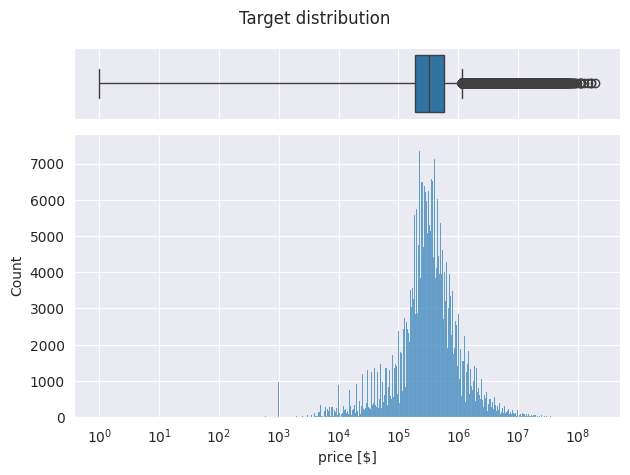

In [3]:
visualize.plot_box_hist_plot(
    df, 
    'target', 
    numeric_label='price [$]', 
    log_scale=True, 
    title='Target distribution',
);

### price <= 1000 $

Сперва оценим значения меньше тыс. долларов

In [7]:
df[df['target']< 1e3].describe()

,baths,sqft,beds,stories,target,year_built,remodeled_year
count,21.000000,33.000000,33.000000,8.000000,77.000000,34.000000,12.000000
mean,2.130952,4153.363636,3.931818,1.750000,455.857143,1915.558824,1965.666667
std,0.533965,12666.236618,1.638493,0.707107,304.881242,40.475351,30.987779
min,1.000000,0.000000,1.500000,1.000000,1.000000,1865.000000,1889.000000
25%,2.000000,1064.000000,3.000000,1.000000,25.000000,1881.250000,1957.000000
50%,2.000000,1656.000000,3.000000,2.000000,600.000000,1900.000000,1969.500000
75%,2.500000,2288.000000,6.000000,2.000000,600.000000,1940.750000,1989.000000
max,3.000000,73260.000000,7.000000,3.000000,950.000000,2005.000000,1996.000000


Видим, что всего 77 строк имеют такую цену, причём больше половины имеют пропуски.
Смело будем удалять их.

Есть большое количество квартир с указанием цены в 1 тыс. долларов

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 374305
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                333918 non-null  object 
 1   street                372469 non-null  object 
 2   baths                 267467 non-null  float64
 3   fireplace             374306 non-null  bool   
 4   city                  374272 non-null  object 
 5   sqft                  333384 non-null  float64
 6   zipcode               374306 non-null  object 
 7   beds                  277504 non-null  float64
 8   state                 374306 non-null  object 
 9   stories               221109 non-null  float64
 10  target                374306 non-null  int64  
 11  marked_interior_area  374306 non-null  bool   
 12  private_pool          374306 non-null  bool   
 13  mls                   374306 non-null  bool   
 14  property_type         333572 non-null  object 
 15  year_

In [23]:
display(df[df['target'] == 1e3].describe())

columns_list = [
    'status', 'property_type', 'state', 'city', 'fireplace', 'price/sqft'
]

for column in columns_list:
    display(df[df['target'] == 1e3][column].value_counts())

,baths,sqft,beds,stories,target,year_built,remodeled_year
count,304.000000,921.000000,881.000000,691.000000,965.0,921.000000,1.0
mean,1.999671,1265.180239,3.246311,1.377713,1000.0,1931.327904,1940.0
std,0.395895,529.946911,0.981390,0.485167,0.0,12.787773,NaN
min,1.000000,0.000000,0.000000,1.000000,1000.0,1886.000000,1940.0
25%,2.000000,874.000000,3.000000,1.000000,1000.0,1923.000000,1940.0
50%,2.000000,1148.000000,3.000000,1.000000,1000.0,1926.000000,1940.0
75%,2.000000,1470.000000,4.000000,2.000000,1000.0,1942.000000,1940.0
max,4.000000,3324.000000,7.000000,2.000000,1000.0,1971.000000,1940.0


status
foreclosure    882
sale            22
active          20
Name: count, dtype: int64

property_type
single    911
land       36
Name: count, dtype: int64

state
MI    910
TN     35
NY     15
FL      4
NC      1
Name: count, dtype: int64

city
Detroit            900
Memphis             34
Albany              14
Highland Park        8
Miami                3
Battle Creek         2
Jacksonville         1
Menands              1
Fort Lauderdale      1
Arlington            1
Name: count, dtype: int64

fireplace
False    760
True     205
Name: count, dtype: int64

price/sqft
$1/sqft    765
$0/sqft     88
$1          31
$2/sqft     20
$0          16
Name: count, dtype: int64

Видим, что большая часть объявлений это аукцион по случаю банкротства в городе-призраке Детройт. Причём речь идёт о домах, а не об участках

Возможно, имеет смысл исключить эти объявления

### 1 000 price < 10 000 $

In [28]:
price_mask = df['target'].between(1e3, 1e4, inclusive='neither')
display(df[price_mask].describe())

columns_list = [
    'status', 'property_type', 'state', 'city'
]

for column in columns_list:
    display(df[price_mask][column].value_counts())

,baths,sqft,beds,stories,target,year_built,remodeled_year
count,1119.000000,1975.000000,393.000000,256.000000,4610.000000,471.000000,130.000000
mean,0.322163,399.706329,3.771628,1.584766,6712.920390,1933.303609,1957.107692
std,0.718625,1325.984711,7.601430,0.720704,2038.996624,33.350798,27.702530
min,0.000000,0.000000,0.000000,0.000000,1100.000000,1860.000000,1895.000000
25%,0.000000,0.000000,2.000000,1.000000,5000.000000,1910.000000,1942.000000
50%,0.000000,0.000000,3.000000,2.000000,6900.000000,1927.000000,1958.500000
75%,0.000000,0.000000,3.000000,2.000000,8400.000000,1953.500000,1973.000000
max,5.000000,34848.000000,64.000000,6.000000,9999.000000,2019.000000,2009.000000


status
active         2177
sale           2082
pending         157
foreclosure      60
contingency       3
auction           1
new               1
Name: count, dtype: int64

property_type
land        3408
single       216
multi         58
mobile        31
apt           29
condo         22
town          10
colonial       2
ranch          2
cape           1
Name: count, dtype: int64

state
FL    3710
TN     123
NC     115
OH     112
NY     107
MI      93
TX      88
IL      66
WA      62
IN      32
PA      28
WI      23
CA      15
MO      12
GA      11
OK       4
VA       3
CO       1
DC       1
MA       1
OR       1
IA       1
KY       1
Name: count, dtype: int64

city
Lehigh Acres        1325
Port Charlotte       601
PORT CHARLOTTE       408
Ocala                254
Punta Gorda          223
                    ... 
Atlanta                1
Saint Pete Beach       1
Palm Coast             1
ST PETE BEACH          1
PT CHARLOTTE           1
Name: count, Length: 202, dtype: int64

In [29]:
display(df[df['property_type'] == 'apt'].describe())

,baths,sqft,beds,stories,target,year_built,remodeled_year
count,259.000000,777.000000,283.000000,181.000000,8.140000e+02,670.000000,86.000000
mean,2.814672,11487.016731,2.954064,6.099448,9.674736e+05,1973.229851,1934.011628
std,1.660770,56229.185990,2.576767,7.822407,1.711611e+06,38.722434,301.123602
min,1.000000,22.000000,0.000000,1.000000,1.200000e+03,1830.000000,0.000000
25%,2.000000,800.000000,2.000000,1.000000,3.022250e+05,1945.000000,1970.250000
50%,2.000000,1050.000000,2.000000,2.000000,5.500000e+05,1981.000000,1981.500000
75%,3.000000,1848.000000,3.000000,7.000000,8.500000e+05,2007.000000,1999.000000
max,13.000000,605018.000000,27.000000,42.000000,1.755000e+07,2019.000000,2018.000000


Большая часть объявлений с такой ценой - земельные участки.

Однако встречаются и отдельные дома, также как и апартаменты.
Последние имеет смысл исключить, так как их нельзя покупать, а только брать в аренду.

# Export

Подготовим датасет для моделирования

In [7]:
# base_df = df.drop(df.dtypes[df.dtypes == 'object'].index, axis=1)
# cols_to_drop = ['marked_interior_area', 'remodeled_year']
# base_df = base_df.drop(cols_to_drop, axis=1)
# base_df.info()
# base_df.head()
# base_df.to_csv(baseline_data)

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 374305
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   baths         267467 non-null  float64
 1   fireplace     374306 non-null  bool   
 2   sqft          333384 non-null  float64
 3   beds          277504 non-null  float64
 4   stories       221109 non-null  float64
 5   target        374306 non-null  int64  
 6   private_pool  374306 non-null  bool   
 7   mls           374306 non-null  bool   
 8   year_built    311041 non-null  float64
dtypes: bool(3), float64(5), int64(1)
memory usage: 21.1 MB
